# Performing Validation of generating LMN coordinate transformation matrix
Date Created: 24-Oct-2025

Date Modified: 06-Nov-2025

Author: Regis John

In [1]:
import pyspedas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trange = ['2015-12-09/05:03:56.5', '2015-12-09/05:03:57.2']

In [3]:
fgm_vars = pyspedas.mms.fgm(trange=trange, probe=1, data_rate='brst',
                            varformat='mms1_fgm_b_gse_brst_l2', time_clip=True)

06-Nov-25 10:46:05: Loading files for group: probe: 1, drate: brst, level: l2, datatype: , after sorting and filtering:
06-Nov-25 10:46:05: /Users/rejohn/Data_Speedas/mms/mms1/fgm/brst/l2/2015/12/09/mms1_fgm_brst_l2_20151209050044_v4.22.0.cdf


In [4]:
fgm_vars

['mms1_fgm_b_gse_brst_l2',
 'mms1_fgm_b_gse_brst_l2_bvec',
 'mms1_fgm_b_gse_brst_l2_btot']

In [5]:
pyspedas.tplot_rename('mms1_fgm_b_gse_brst_l2_bvec', 'bvec_gse')

In [6]:
from pyspedas import minvar_matrix_make

minvar_matrix_make(
    in_var_name='bvec_gse',  # or GSM if that's your input frame
    tstart='2015-12-09/05:03:56.5',
    tstop='2015-12-09/05:03:57.2',
    tslide=0,     # single matrix
)


06-Nov-25 10:46:06: store_data: Neither data array nor newname supplied, nothing to do.


['bvec_gse_mva_mat']

In [7]:
times, lmn_matrix = pyspedas.get_data('bvec_gse_mva_mat')

In [8]:
times.shape

(1,)

In [9]:
lmn_matrix.shape

(1, 3, 3)

## Resolving LMN Sign Ambiguity (MVA in GSE)

The eigen vectors L, M, and N from minimum variance analysis (MVA) are unique only up to a sign. To align with the LMN system published in Wilder et al. (2017), which expresses vectors in **GSE coordinates**, we fix signs using physical context and directional conventions.

- **N** is explicitly chosen to point outward from the magnetopause into the magnetosheath, which corresponds to the **positive GSE X direction near magnetic local noon** (Wilder et al., 2017). As noted in Hapgood (1992), “it is necessary to check that N points outward, i.e. away from the object (planet, comet) which supports the boundary.”
- **L** is explicitly chosen to align with the reconnecting magnetic field and lie within the magnetopause plane. Following Hapgood (1992), we ensure **L has a positive projection along the GSE Z-axis**, consistent with the projection of the solar magnetospheric Z direction: “The L direction must lie within the plane defined by the other two eigenvectors but otherwise the choice of direction is arbitrary. One choice is to select the projection of solar magnetospheric Z direction onto this plane.”
- **M** is then defined as `M = N × L` to complete a right-handed system.

The x-component of N is positive so it is pointing outward, so no change needed.

In [10]:
N = lmn_matrix[0][2]

The z-component of L is negative so we reverse the sign of L.

In [11]:
L = - lmn_matrix[0][0]

To ensure right handedness, we reverse the sign of M as well:

In [12]:
M = - lmn_matrix[0][1]

In [13]:
lmn_matrix_corrected = np.vstack([L, M, N]).reshape(1, 3, 3)
lmn_matrix_corrected

array([[[-0.11008219, -0.59222133,  0.7982204 ],
        [ 0.36703702, -0.77055795, -0.52107991],
        [ 0.92366971,  0.23561482,  0.30219186]]])

In [14]:
pyspedas.store_data('lmn_matrix_corrected', data={'x': times, 'y': lmn_matrix_corrected})

True

In [15]:
# Adding metadata that the matrix transforms vectors FROM GSE TO LMN.
pyspedas.rotmat_set_coords(varname='lmn_matrix_corrected', in_coords='GSE', out_coords='LMN')

06-Nov-25 10:46:15: store_data: Neither data array nor newname supplied, nothing to do.


The LMN coordinate system from the Wilder et al. (2017) study is defined as follows:

In [16]:
L = [-0.104, -0.59, 0.80]
M = [0.38, -0.77, -0.514]
N = [0.920, 0.250, 0.302]

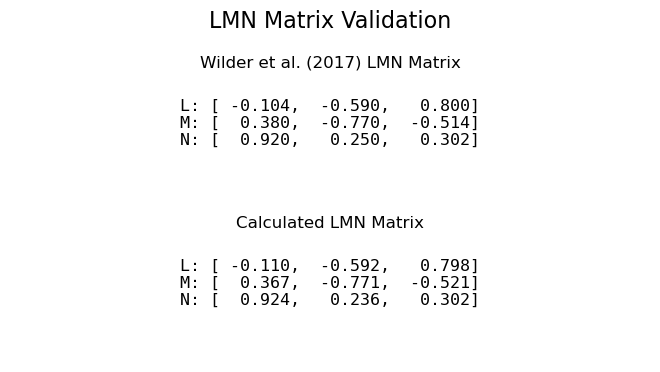

In [17]:
# Create figure with 2 vertically stacked subplots
fig = plt.figure(figsize=(8, 4))

# Create two subplots with specific positions
# [left, bottom, width, height]
ax1 = plt.axes([0.1, 0.5, 0.8, 0.35])
ax2 = plt.axes([0.1, 0.1, 0.8, 0.35])
ax1.axis('off')
ax2.axis('off')

# Round matrices to 3 decimal places
matrix1 = np.around(np.array([L, M, N]), decimals=3)
matrix2 = np.around(lmn_matrix_corrected[0], decimals=3)

# Function to create matrix string
def matrix_to_string(matrix, row_labels):
    matrix_str = ""
    for i, (row, label) in enumerate(zip(matrix, row_labels)):
        matrix_str += f"{label}: [{row[0]:7.3f}, {row[1]:7.3f}, {row[2]:7.3f}]\n"
    return matrix_str

# Add matrices as text
row_labels = ['L', 'M', 'N']
ax1.text(0.5, 0.5, matrix_to_string(matrix1, row_labels),
         ha='center', va='center', fontfamily='monospace', fontsize=12)
ax2.text(0.5, 0.5, matrix_to_string(matrix2, row_labels),
         ha='center', va='center', fontfamily='monospace', fontsize=12)

# Add titles
ax1.set_title('Wilder et al. (2017) LMN Matrix', y=0.9)
ax2.set_title('Calculated LMN Matrix', y=0.9)

# Add overall title
fig.suptitle('LMN Matrix Validation', fontsize=16)

# Save the figure
plt.savefig('lmn_matrix_validation.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot of bulk flow velocities in LMN coordinates

In [18]:
fpi_vars = pyspedas.mms.fpi(trange=trange, 
                            datatype=['des-moms', 'dis-moms'], 
                            level='l2', 
                            data_rate='brst',
                            varnames=['mms1_dis_bulkv_gse_brst',
                                       'mms1_des_bulkv_gse_brst'],
                            time_clip=True)

06-Nov-25 10:46:25: Loading files for group: probe: 1, drate: brst, level: l2, datatype: des-moms, after sorting and filtering:
06-Nov-25 10:46:25: /Users/rejohn/Data_Speedas/mms/mms1/fpi/brst/l2/des-moms/2015/12/09/mms1_fpi_brst_l2_des-moms_20151209050044_v3.3.0.cdf
06-Nov-25 10:46:25: Loading files for group: probe: 1, drate: brst, level: l2, datatype: dis-moms, after sorting and filtering:
06-Nov-25 10:46:25: /Users/rejohn/Data_Speedas/mms/mms1/fpi/brst/l2/dis-moms/2015/12/09/mms1_fpi_brst_l2_dis-moms_20151209050044_v3.3.0.cdf
06-Nov-25 10:46:25: The name mms1_des_errorflags_brst is currently not in pytplot
06-Nov-25 10:46:25: The name mms1_des_compressionloss_brst is currently not in pytplot
06-Nov-25 10:46:25: The name mms1_dis_errorflags_brst is currently not in pytplot
06-Nov-25 10:46:25: The name mms1_dis_compressionloss_brst is currently not in pytplot
06-Nov-25 10:46:25: The name mms1_des_pitchangdist_lowen_brst is currently not in pytplot
06-Nov-25 10:46:25: The name mms1_de

In [19]:
fpi_vars

['mms1_des_bulkv_gse_brst',
 'mms1_dis_bulkv_gse_brst',
 'mms1_des_errorflags_brst_moms',
 'mms1_des_compressionloss_brst_moms',
 'mms1_dis_errorflags_brst_moms',
 'mms1_dis_compressionloss_brst_moms']

In [20]:
edp_vars = pyspedas.mms.edp(trange=trange,
                            probe=1,
                            data_rate='brst',
                            varnames=['mms1_edp_dce_gse_brst_l2', 'mms1_edp_dce_par_epar_brst_l2'],
                            time_clip=True)

06-Nov-25 10:46:28: Loading files for group: probe: 1, drate: brst, level: l2, datatype: dce, after sorting and filtering:
06-Nov-25 10:46:28: /Users/rejohn/Data_Speedas/mms/mms1/edp/brst/l2/dce/2015/12/09/mms1_edp_brst_l2_dce_20151209050044_v2.2.0.cdf


In [21]:
pyspedas.tplot_rename('mms1_dis_bulkv_gse_brst', 'bulk_vi')
pyspedas.tplot_rename('mms1_des_bulkv_gse_brst', 'bulk_ve')
pyspedas.tplot_rename('mms1_edp_dce_gse_brst_l2', 'evec_gse')

In [22]:
times, bulk_ve = pyspedas.get_data('bulk_ve')
times, bulk_vi = pyspedas.get_data('bulk_vi')
times, bvec_gse = pyspedas.get_data('bvec_gse')
times, evec_gse = pyspedas.get_data('evec_gse')

In [23]:
evec_gse.shape, bvec_gse.shape, bulk_ve.shape, bulk_vi.shape

((5734, 3), (89, 3), (23, 3), (5, 3))

### Downsampling to DES cadence of 30 ms

In [24]:
# Define target cadence
des_cadence = 0.03  # seconds or 30 ms

In [25]:
# 1. Downsample magnetic field (native ~128 Hz → 33 Hz)
pyspedas.avg_data('bvec_gse', res=des_cadence, newname='bvec_gse_avg')

06-Nov-25 10:46:29: avg_data was applied to: bvec_gse_avg


['bvec_gse_avg']

In [26]:
# 2. Downsample electric field (native 8192 Hz → 33 Hz)
pyspedas.avg_data('evec_gse', res=des_cadence, newname='evec_gse_avg')

06-Nov-25 10:46:29: avg_data was applied to: evec_gse_avg


['evec_gse_avg']

In [27]:
# 4. Interpolate ion bulk velocity (native ~6.75 Hz → 33 Hz)
pyspedas.tinterpol( names='bulk_vi', interp_to='bulk_ve', newname='bulk_vi_interp',
                   method='linear')


06-Nov-25 10:46:30: tinterpol (linear) was applied to: bulk_vi_interp


### Rotating bulk velocity to LMN coordinates

In [28]:
pyspedas.tvector_rotate(mat_var_in='lmn_matrix_corrected',vec_var_in='bulk_ve',
                        newname='bulk_ve_lmn')
pyspedas.tvector_rotate(mat_var_in='lmn_matrix_corrected',vec_var_in='bulk_vi_interp',
                        newname='bulk_vi_lmn')

06-Nov-25 10:46:30: Setting coordinate system for bulk_ve_lmn
06-Nov-25 10:46:30: Setting coordinate system for bulk_vi_lmn


['bulk_vi_lmn']

### Rotating magnetic field vector to LMN coordinates

In [29]:
pyspedas.tvector_rotate(mat_var_in='lmn_matrix_corrected',vec_var_in='bvec_gse_avg',
                        newname='bvec_lmn')

06-Nov-25 10:46:31: Setting coordinate system for bvec_lmn


['bvec_lmn']

### Rotating electric field vector to LMN coordinates

In [30]:
pyspedas.tvector_rotate(mat_var_in='lmn_matrix_corrected',vec_var_in='evec_gse_avg',
                        newname='evec_lmn')

06-Nov-25 10:46:32: Setting coordinate system for evec_lmn


['evec_lmn']

In [31]:
pyspedas.timespan(trange) 

In [32]:
# Panel 6 - Electron bulk velocity in LMN
pyspedas.options('bulk_ve_lmn', 'legend_names', ['$L$', '$M$', '$N$'])
pyspedas.options('bulk_ve_lmn', 'ytitle', '$V_{EMVA}$')
pyspedas.options('bulk_ve_lmn', 'line_width', 1.5)

In [33]:
pyspedas.options('bulk_ve_lmn', 'y_range', [-1000, 600])
# Set y-axis ticks for the variable
pyspedas.options('bulk_ve_lmn', 'y_major_ticks', [-800, -400, 0, 400])

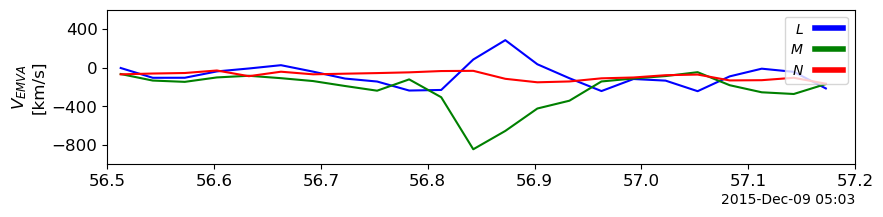

In [34]:
pyspedas.tplot(['bulk_ve_lmn'], xsize=8.72, ysize=2.14, dpi=200, 
               save_png='Fig4_Oct31_lmn_comparison.png')